# Assymetries of Warming and Cooling (Albedo Feedback)

## By Peyton Capute

### May 10, 2019

##### THE APRP CODE PRESENTED HERE WAS  ADAPTED FROM:
##### Mark Zelinka (https://github.com/mzelinka/aprp).


###### THE EQUATIONS ARE FROM TAYLOR ET AL. (2007)

This code used annual mean CESM data to calculate APRP radiative responses.

### READING IN DATA

In [1]:
%matplotlib inline
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
#import cdms2
#from cdms2 import MV
import numpy as np
#import cdms2 as cdms
#import cdutil
import pylab as pl
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs

# Load in CESM data
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
            'cpl_CO2rampdown': 'cpl_CO2rampdown_f19',
            }
# The path to the THREDDS server, should work from anywhere
basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'
    
# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)
    


Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2rampdown_f19/concatenated/cpl_CO2rampdown_f19.cam.h0.nc


### FUNCTIONS

In [2]:
#  The area weighting needed for global averaging
gw = atm['cpl_control'].gw

def global_mean(field, weight=gw):
    '''Return the area-weighted global average of the input field'''
    return (field*weight).mean(dim=('lat','lon'))/weight.mean(dim='lat')

def make_map_field(field):
    '''input field should be a 2D xarray.DataArray on a lat/lon grid.
        Make a filled contour plot of the field, and a line plot of the zonal mean
    '''
    fig = plt.figure(figsize=(14,6))
    nrows = 10; ncols = 3
    mapax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=nrows-1, projection=ccrs.Robinson())
    barax = plt.subplot2grid((nrows,ncols), (nrows-1,0), colspan=ncols-1)
    plotax = plt.subplot2grid((nrows,ncols), (0,ncols-1), rowspan=nrows-1)
    cx = mapax.contourf(field.lon, field.lat, field, transform=ccrs.PlateCarree())
    mapax.set_global(); mapax.coastlines();
    plt.colorbar(cx, cax=barax, orientation='horizontal')
    plotax.plot(field.mean(dim='lon'), field.lat)
    plotax.set_ylabel('Latitude')
    plotax.grid()
    return fig, (mapax, plotax, barax), cx

#Function to calculate the planetary albedo, A.
#Inputs: (see Fig. 1 of Taylor et al., 2007)
#   c: fraction of the region occupied by clouds
#   a_clr: clear sky surface albedo (SW flux up / SW flux down)
#   a_oc: overcast surface albedo
#   mu_clr: clear-sky transmittance of SW radiation
#   mu_cld: cloudy-sky transmittance of SW radiation
#   ga_clr: clear-sky atmospheric scattering coefficient
#   ga_cld: cloudy-sky atmospheric scattering coefficient
def albedo(c, a_clr, a_oc, mu_clr, mu_cld, ga_clr, ga_cld): #Labeled with equation numbers from Taylor et al. 2007
    mu_oc = mu_clr*mu_cld                                                            #Eq. 14
    ga_oc =  1. - (1.-ga_clr)*(1.-ga_cld)                                            #Eq. 13
    A_clr = mu_clr*ga_clr + mu_clr*a_clr*(1.-ga_clr)*(1.-ga_clr)/(1.-a_clr*ga_clr)   #Eq. 7 (clear-sky)
    A_oc = mu_oc*ga_oc + mu_oc*a_oc*(1.-ga_oc)*(1.-ga_oc)/(1.-a_oc*ga_oc)            #Eq. 7 (overcast sky)
    A = (1-c)*A_clr + c*A_oc    # equation 15                                                      #Eq. 15
    return A

def parameters(SWupsfccs,SWdnsfccs,SWdn,SWupcs,SWupsfcoc,SWdnsfcoc,SWupoc):

    """
    This function is called by APRP
    Equation numbers refer to Taylor et al. (2007)
    """
    
    #calculating clear sky parameters
    a_clr=SWupsfccs/SWdnsfccs # albedo
    Q=SWdnsfccs/SWdn # ratio of incident sfc flux to TOA insolation
    mu_clr=SWupcs/SWdn + Q*(1-a_clr) # Eq. 9
    ga_clr=(mu_clr-Q)/(mu_clr-a_clr*Q) # Eq. 10

    # calculating overcast parameters
    a_oc=SWupsfcoc/SWdnsfcoc # albedo
    Q=SWdnsfcoc/SWdn # ratio of incident sfc flux to TOA insolation
    mu_oc=SWupoc/SWdn + Q*(1-a_oc) # Eq. 9
    ga_oc=(mu_oc-Q)/(mu_oc-a_oc*Q) # Eq. 10

    # calculating cloud parameters through clear sky and overcast parameters
    mu_cld=mu_oc/mu_clr  # Eq. 14 sometimes this is greater than 1??
    ga_cld=(ga_oc-1)/(1-ga_clr)+1  # Eq. 13
    
    return (a_clr,mu_clr,ga_clr,a_oc,mu_cld,ga_cld)  

def APRP(ctl_clt,ctl_rsdt,ctl_rsut,ctl_rsutcs,ctl_rsds,ctl_rsus,ctl_rsdscs,ctl_rsuscs,\
         pert_clt,pert_rsdt,pert_rsut,pert_rsutcs,pert_rsds,pert_rsus,pert_rsdscs,pert_rsuscs):
    """
    Perform APRP calculations 
    
    Reference: Taylor, K. E. et al. (2007), Estimating shortwave radiative forcing and response in 
    climate models, J. Clim., 20(11), 2530-2543, doi:10.1175/JCLI4143.1.
    
    input: total cloud cover and SW radiative fluxes at TOA and SFC for clear- and all-sky conditions
           -standard CMIP nomenclature, with prefixes that refer to the control (ctl_*) and perturbed climate (pert_*) 
    
    output: TOA SW anomalies due to changes in:
            -surface albedo (for all-, clear-, and overcast-sky conditions)
            -clouds (total change and contributions from changing cloud cover, scattering, and absorption)
            -non-cloud atmosphere (e.g., from changes in water vapor, aerosols, ozone)
            
    functions called: parameters() and albedo()
    """
    
    # Make sure the cld fractions are expressed as fraction and not percent
#     if np.amax(ctl_clt)>1.:
#         ctl_clt=ctl_clt/100.
#     if np.amax(pert_clt)>1.:
#         pert_clt=pert_clt/100.

    # Derive overcast conditions
    ctl_rsut_cld=(1/ctl_clt)*(ctl_rsut-(1-ctl_clt)*ctl_rsutcs)
    ctl_rsds_cld=(1/ctl_clt)*(ctl_rsds-(1-ctl_clt)*ctl_rsdscs)
    ctl_rsus_cld=(1/ctl_clt)*(ctl_rsus-(1-ctl_clt)*ctl_rsuscs)
    pert_rsut_cld=(1/pert_clt)*(pert_rsut-(1-pert_clt)*pert_rsutcs)
    pert_rsds_cld=(1/pert_clt)*(pert_rsds-(1-pert_clt)*pert_rsdscs)
    pert_rsus_cld=(1/pert_clt)*(pert_rsus-(1-pert_clt)*pert_rsuscs)

    #print("size of derive overcast")
    #print(np.size(ctl_rsut_cld))
    
    # Mask these where values are unphysical   
    ctl_rsds_cld=np.ma.masked_where(ctl_rsds_cld > ctl_rsds,ctl_rsds_cld)
    ctl_rsus_cld=np.ma.masked_where(ctl_rsus_cld > ctl_rsus,ctl_rsus_cld)
    ctl_rsut_cld=np.ma.masked_where(ctl_rsut_cld < 0,ctl_rsut_cld)
    ctl_rsds_cld=np.ma.masked_where(ctl_rsds_cld < 0,ctl_rsds_cld)
    ctl_rsus_cld=np.ma.masked_where(ctl_rsus_cld < 0,ctl_rsus_cld)

    #print("size of mask")
    #print(np.size(ctl_rsut_cld))
    
    pert_rsds_cld=np.ma.masked_where(pert_rsds_cld > pert_rsds,pert_rsds_cld)
    pert_rsus_cld=np.ma.masked_where(pert_rsus_cld > pert_rsus,pert_rsus_cld)
    pert_rsut_cld=np.ma.masked_where(pert_rsut_cld < 0,pert_rsut_cld)
    pert_rsds_cld=np.ma.masked_where(pert_rsds_cld < 0,pert_rsds_cld)
    pert_rsus_cld=np.ma.masked_where(pert_rsus_cld < 0,pert_rsus_cld)    

    ## NOW THE FORMAL APRP CALCULATIONS:
    a_clr1,mu_clr1,ga_clr1,a_oc1,mu_cld1,ga_cld1 = \
        parameters(ctl_rsuscs,ctl_rsdscs,ctl_rsdt,ctl_rsutcs,ctl_rsus_cld,ctl_rsds_cld,ctl_rsut_cld) # control
    a_clr2,mu_clr2,ga_clr2,a_oc2,mu_cld2,ga_cld2 = \
        parameters(pert_rsuscs,pert_rsdscs,pert_rsdt,pert_rsutcs,pert_rsus_cld,pert_rsds_cld,pert_rsut_cld) # perturbed    

    ## Taylor et al. (2007) Eqn. 12b:
    A_1=albedo(ctl_clt,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld1)
    A_2=albedo(pert_clt,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld2)

    dA_amt_cld=     0.5*(albedo(pert_clt,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(ctl_clt,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld2))
    dA_a_clr=       0.5*(albedo(ctl_clt,a_clr2,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr1,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld2))
    dA_a_oc=        0.5*(albedo(ctl_clt,a_clr1,a_oc2,mu_clr1,mu_cld1,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc1,mu_clr2,mu_cld2,ga_clr2,ga_cld2))
    dA_abs_noncld=  0.5*(albedo(ctl_clt,a_clr1,a_oc1,mu_clr2,mu_cld1,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc2,mu_clr1,mu_cld2,ga_clr2,ga_cld2))
    dA_abs_cld=     0.5*(albedo(ctl_clt,a_clr1,a_oc1,mu_clr1,mu_cld2,ga_clr1,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc2,mu_clr2,mu_cld1,ga_clr2,ga_cld2))
    dA_scat_noncld= 0.5*(albedo(ctl_clt,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr2,ga_cld1)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr1,ga_cld2))
    dA_scat_cld=    0.5*(albedo(ctl_clt,a_clr1,a_oc1,mu_clr1,mu_cld1,ga_clr1,ga_cld2)-A_1) + \
                0.5*(A_2-albedo(pert_clt,a_clr2,a_oc2,mu_clr2,mu_cld2,ga_clr2,ga_cld1))

    # if the cld fraction is less than 2%, set fields to be zero
    dA_amt_cld=np.where(ctl_clt<0.02,0.,dA_amt_cld)
    dA_amt_cld=np.where(pert_clt<0.02,0.,dA_amt_cld)
    dA_a_oc=np.where(ctl_clt<0.02,0.,dA_a_oc)
    dA_a_oc=np.where(pert_clt<0.02,0.,dA_a_oc)
    dA_abs_cld=np.where(ctl_clt<0.02,0.,dA_abs_cld)
    dA_abs_cld=np.where(pert_clt<0.02,0.,dA_abs_cld)
    dA_scat_cld=np.where(ctl_clt<0.02,0.,dA_scat_cld)
    dA_scat_cld=np.where(pert_clt<0.02,0.,dA_scat_cld)

    dA_a=dA_a_clr+dA_a_oc
    dA_cld=dA_abs_cld+dA_scat_cld+dA_amt_cld
    dA_noncld=dA_abs_noncld+dA_scat_noncld

    ## TOA SW Anomalies due to Surface Albedo Anomalies
    sfc_alb=-dA_a*ctl_rsdt
    sfc_alb_clr=-dA_a_clr*ctl_rsdt   
    sfc_alb_oc=-dA_a_oc*ctl_rsdt

    ## TOA SW Anomalies due to Cloud Anomalies
    cld=-dA_cld*ctl_rsdt
    cld_amt=-dA_amt_cld*ctl_rsdt    
    cld_scat=-dA_scat_cld*ctl_rsdt
    cld_abs=-dA_abs_cld*ctl_rsdt

    ## TOA SW Anomalies due to Non-cloud Anomalies
    noncld=-dA_noncld*ctl_rsdt
    noncld_scat=-dA_scat_noncld*ctl_rsdt  
    noncld_abs=-dA_abs_noncld*ctl_rsdt

    return (sfc_alb,sfc_alb_clr,sfc_alb_oc,cld,cld_amt,cld_scat,cld_abs,noncld,noncld_scat,noncld_abs)

In [3]:
# Latitude and Longitude gridding from data
lat = atm['cpl_control'].lat
lon = atm['cpl_control'].lon

### OBTAINING CESM FIELDS - AVERAGING OVER LAST 20 YEARS FOR EACH SIMULATION

In [4]:
# Net downward solar flux at surface
cpl_ctr_fsns = atm['cpl_control'].FSNS.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_fsns = atm['cpl_CO2ramp'].FSNS.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_fsns = atm['cpl_CO2rampdown'].FSNS.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

# Net clearsky downward solar flux at surface
cpl_ctr_fsnsc = atm['cpl_control'].FSNSC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_fsnsc = atm['cpl_CO2ramp'].FSNSC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_fsnsc = atm['cpl_CO2rampdown'].FSNSC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

# Flux Shortwave Downwelling at Surface
cpl_ctr_fsds = atm['cpl_control'].FSDS.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_fsds = atm['cpl_CO2ramp'].FSDS.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_fsds = atm['cpl_CO2rampdown'].FSDS.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

# Downwelling clearsky downward solar flux at surface
cpl_ctr_fsdsc = atm['cpl_control'].FSDSC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_fsdsc = atm['cpl_CO2ramp'].FSDSC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_fsdsc = atm['cpl_CO2rampdown'].FSDSC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

# Net downward solar flux at top of model
cpl_ctr_fsnt = atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_fsnt = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_fsnt = atm['cpl_CO2rampdown'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

# Net clearsky downward solar flux at top of model.
cpl_ctr_fsntc = atm['cpl_control'].FSNTC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_fsntc = atm['cpl_CO2ramp'].FSNTC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_fsntc = atm['cpl_CO2rampdown'].FSNTC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

# Net downward solar flux at top of atmosphere
cpl_ctr_fsntoa = atm['cpl_control'].FSNTOA.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_fsntoa = atm['cpl_CO2ramp'].FSNTOA.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_fsntoa = atm['cpl_CO2rampdown'].FSNTOA.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

 # Net clearsky downward solar flux at top of atmosphere.
cpl_ctr_fsntoac = atm['cpl_control'].FSNTOAC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_fsntoac = atm['cpl_CO2ramp'].FSNTOAC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_fsntoac = atm['cpl_CO2rampdown'].FSNTOAC.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

# ???
cpl_ctr_fsutoa = atm['cpl_control'].FSUTOA.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_fsutoa = atm['cpl_CO2ramp'].FSUTOA.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_fsutoa = atm['cpl_CO2rampdown'].FSUTOA.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

# fraction of total cloud cover (c)
cpl_ctr_cldtot = atm['cpl_control'].CLDTOT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_2xCO2_cldtot = atm['cpl_CO2ramp'].CLDTOT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
cpl_halfxCO2_cldtot = atm['cpl_CO2rampdown'].CLDTOT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

### COMPUTE VARIABLES NEEDED ###

# Short-wave: net = down - up
cpl_ctr_rsus = (cpl_ctr_fsds - cpl_ctr_fsns)
cpl_2xCO2_rsus = (cpl_2xCO2_fsds - cpl_2xCO2_fsns)
cpl_halfxCO2_rsus = cpl_halfxCO2_fsds - cpl_halfxCO2_fsns

# Down = net + up
cpl_ctr_rsdt = (cpl_ctr_fsutoa + cpl_ctr_fsntoa)
cpl_2xCO2_rsdt = (cpl_2xCO2_fsutoa + cpl_2xCO2_fsntoa)
cpl_halfxCO2_rsdt = cpl_halfxCO2_fsutoa + cpl_halfxCO2_fsntoa

# ???
cpl_ctr_rsuscs = (cpl_ctr_fsdsc - cpl_ctr_fsnsc)
cpl_2xCO2_rsuscs = (cpl_2xCO2_fsdsc - cpl_2xCO2_fsnsc)
cpl_halfxCO2_rsuscs = cpl_halfxCO2_fsdsc - cpl_halfxCO2_fsnsc

# Downward shortwave at TOA should be same regardless of clouds
cpl_ctr_rsutcs = (cpl_ctr_rsdt - cpl_ctr_fsntoac)
cpl_2xCO2_rsutcs = (cpl_2xCO2_rsdt - cpl_2xCO2_fsntoac)
cpl_halfxCO2_rsutcs = cpl_halfxCO2_rsdt - cpl_halfxCO2_fsntoac


### Running APRP calculations between control and perturbed simulations

In [5]:
# Running APRP calculations between control and perturbed simulations

double_aprp = (sfc_alb,sfc_alb_clr,sfc_alb_oc,cld,cld_amt,cld_scat,cld_abs,noncld,noncld_scat,noncld_abs) = \
    APRP(cpl_ctr_cldtot,cpl_ctr_rsdt,cpl_ctr_fsutoa,cpl_ctr_rsutcs,cpl_ctr_fsds,cpl_ctr_rsus,cpl_ctr_fsdsc,cpl_ctr_rsuscs,\
         cpl_2xCO2_cldtot,cpl_2xCO2_rsdt,cpl_2xCO2_fsutoa,cpl_2xCO2_rsutcs,cpl_2xCO2_fsds,cpl_2xCO2_rsus,cpl_2xCO2_fsdsc,cpl_2xCO2_rsuscs)

half_aprp = (sfc_alb,sfc_alb_clr,sfc_alb_oc,cld,cld_amt,cld_scat,cld_abs,noncld,noncld_scat,noncld_abs) = \
    APRP(cpl_ctr_cldtot,cpl_ctr_rsdt,cpl_ctr_fsutoa,cpl_ctr_rsutcs,cpl_ctr_fsds,cpl_ctr_rsus,cpl_ctr_fsdsc,cpl_ctr_rsuscs,\
        cpl_halfxCO2_cldtot,cpl_halfxCO2_rsdt,cpl_halfxCO2_fsutoa,cpl_halfxCO2_rsutcs,cpl_halfxCO2_fsds,cpl_halfxCO2_rsus,cpl_halfxCO2_fsdsc,cpl_halfxCO2_rsuscs)



### Looking at simulations CO2 concentrations and temperatures

In [6]:
#  Loop through the four simulations and produce the global mean timeseries
TREFHT_global = {}
for name in casenames:
    TREFHT_global[name] = global_mean(atm[name].TREFHT)
    
# Calculating the transient climate response (TCR)

T0_cpl = TREFHT_global['cpl_control'].isel(time=slice(-(20*12+1),-1)).mean(dim='time')
T2x_cpl = TREFHT_global['cpl_CO2ramp'].isel(time=slice(-(20*12+1),-1)).mean(dim='time')
Thalfx_cpl = TREFHT_global['cpl_CO2rampdown'].isel(time=slice(-(20*12+1),-1)).mean(dim='time')

TCR_double = T2x_cpl - T0_cpl
TCR_half = Thalfx_cpl - T0_cpl

#print(TCR_double) 
#print(TCR_half) 

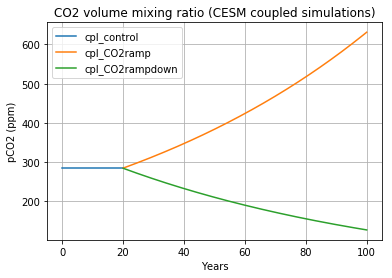

In [7]:
days_per_year = 365
fig, ax = plt.subplots()
for name in ['cpl_control', 'cpl_CO2ramp', 'cpl_CO2rampdown']:
    ax.plot(atm[name].time/days_per_year, atm[name].co2vmr*1E6, label=name)
ax.set_title('CO2 volume mixing ratio (CESM coupled simulations)')
ax.set_xlabel('Years')
ax.set_ylabel('pCO2 (ppm)')
ax.grid()
ax.legend();

No handles with labels found to put in legend.


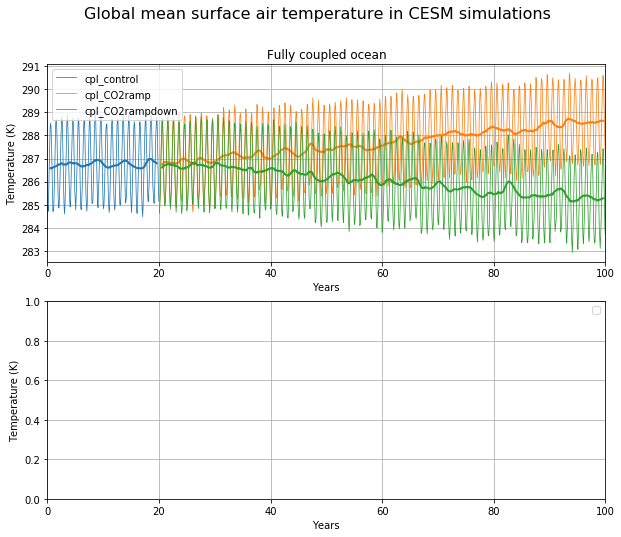

In [8]:
fig, axes = plt.subplots(2,1,figsize=(10,8))
for name in casenames:
    if 'cpl' in name:
        ax = axes[0]
        ax.set_title('Fully coupled ocean')
    else:
        ax = axes[1]
        ax.set_title('Slab ocean')
    field = TREFHT_global[name]
    field_running = field.rolling(time=12, center=True).mean()
    line = ax.plot(field.time / days_per_year, 
                   field, 
                   label=name,
                   linewidth=0.75,
                   )
    ax.plot(field_running.time / days_per_year, 
            field_running, 
            color=line[0].get_color(),
            linewidth=2,
           )
for ax in axes:
    ax.legend();
    ax.set_xlabel('Years')
    ax.set_ylabel('Temperature (K)')
    ax.grid();
    ax.set_xlim(0,100)
fig.suptitle('Global mean surface air temperature in CESM simulations', fontsize=16);

### Calculating TOA energy budget, ASR, OLR, ASR - OLR

In [9]:
# Subtracting Net upward longwave flux at top of model (FLNT) from Net downward solar flux at top of atmosphere (FSNT) 

ctr_NEB = atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time') - atm['cpl_control'].FLNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
double_NEB = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time') - atm['cpl_CO2ramp'].FLNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
half_NEB = atm['cpl_CO2rampdown'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time') - atm['cpl_CO2rampdown'].FLNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')

#rint(global_mean(ctr_NEB))
#print(global_mean(double_NEB))
#print(global_mean(half_NEB))


In [10]:
# changes is ASR and OLR for each experiment

cpl_ASR_double = atm['cpl_CO2ramp'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time') - atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
#fig, axes, cx = make_map_field(cpl_ASR_double)
#fig.suptitle('Change in ASR for 2xCO2 (coupled transient)', fontsize=16);

cpl_OLR_double = atm['cpl_CO2ramp'].FLNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time') - atm['cpl_control'].FLNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
#fig, axes, cx = make_map_field(cpl_OLR_double)
#fig.suptitle('Change in OLR for 2xCO2 (coupled transient)', fontsize=16);

cpl_ASR_half = atm['cpl_CO2rampdown'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time') - atm['cpl_control'].FSNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
#fig, axes, cx = make_map_field(cpl_ASR_half)
#fig.suptitle('Change in ASR 0.5xCO2 (coupled transient)', fontsize=16);

cpl_OLR_half = atm['cpl_CO2rampdown'].FLNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time') - atm['cpl_control'].FLNT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
#fig, axes, cx = make_map_field(cpl_OLR_half)
#fig.suptitle('Change in OLR for 0.5xCO2 (coupled transient)', fontsize=16);

In [11]:
double_net_change = cpl_ASR_double - cpl_OLR_double
half_net_change = cpl_ASR_half - cpl_OLR_half

#fig, axes, cx = make_map_field(double_net_change)
#fig, axes, cx = make_map_field(half_net_change)


### Surface Temp Calculations and plots

In [12]:
# Calculating and plotting surface air temp anomalies 

Tmap_cpl_2x = atm['cpl_CO2ramp'].TREFHT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
Tmap_cpl_control = atm['cpl_control'].TREFHT.isel(time=slice(-(20*12+1),-1)).mean(dim='time')
Tmap_half_x = atm['cpl_CO2rampdown'].TREFHT.isel(time=slice(-(10*12+1),-1)).mean(dim='time')
DeltaT_double = Tmap_cpl_2x - Tmap_cpl_control
DeltaT_half = Tmap_half_x - Tmap_cpl_control

#fig, axes, cx = make_map_field(DeltaT_double)
#fig.suptitle('Surface air temperature anomaly (coupled transient) 2xCO2', fontsize=16);
#axes[1].set_xlim(0,7)  # ensure the line plots have same axes
#cx.set_clim([0, 8])    # ensure the contour maps have the same color intervals

#fig, axes, cx = make_map_field(DeltaT_half)
#fig.suptitle('Surface air temperature anomaly (coupled transient) 0.5xCO2', fontsize=16);
#axes[1].set_xlim(0,7)  # ensure the line plots have same axes
#cx.set_clim([0, 8])    # ensure the contour maps have the same color intervals

### Plotting APRP responses

In [13]:
# UNCOMMENT BELOW TO PLOT CO2ramp RESULTS

# fig, axes, cx = make_map_field(double_aprp[0])
# fig, axes, cx = make_map_field(double_aprp[1])
# fig, axes, cx = make_map_field(double_aprp[2])
# fig, axes, cx = make_map_field(double_aprp[3])
# fig, axes, cx = make_map_field(double_aprp[4])
# fig, axes, cx = make_map_field(double_aprp[5])
# fig, axes, cx = make_map_field(double_aprp[6])
# fig, axes, cx = make_map_field(double_aprp[7])
# fig, axes, cx = make_map_field(double_aprp[8])
# fig, axes, cx = make_map_field(double_aprp[9])

In [14]:
# UNCOMMENT BELOW TO PLOT CO2rampdown RESULTS

# fig, axes, cx = make_map_field(half_aprp[0])
# fig, axes, cx = make_map_field(half_aprp[1])
# fig, axes, cx = make_map_field(half_aprp[2])
# fig, axes, cx = make_map_field(half_aprp[3])
# fig, axes, cx = make_map_field(half_aprp[4])
# fig, axes, cx = make_map_field(half_aprp[5])
# fig, axes, cx = make_map_field(half_aprp[6])
# fig, axes, cx = make_map_field(half_aprp[7])
# fig, axes, cx = make_map_field(half_aprp[8])
# fig, axes, cx = make_map_field(half_aprp[9])